In [2]:
import os

from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI

QI_URL = os.getenv('QI_URL', 'https://api.quantum-inspire.com/')

from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer
import numpy as np
#References https://learn.qiskit.org/course/quantum-hardware/introduction-to-quantum-error-correction-via-the-repetition-code#introduction-6-0


In [3]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

/tmp/ipykernel_95/2539325069.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.topological_codes import RepetitionCode


In [25]:
#Noise model
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate,p_reset):

    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_reset, "reset")# reset error applied to all qubits
    
    return noise_model

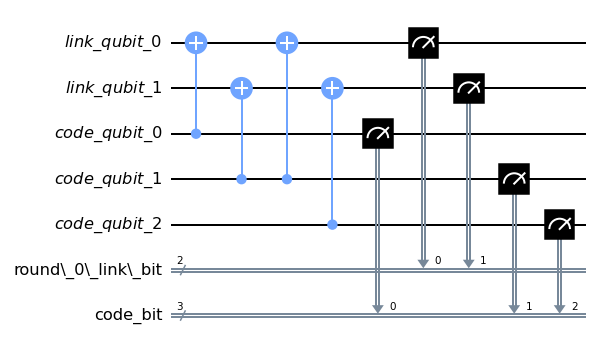

In [26]:
n = 3  #repetitions
T = 1  #syndrome measurements

code = RepetitionCode(n,T)
#code.circuit['0'].draw(output='mpl')
qc0=code.circuit['0']
qc0.draw(output='mpl')


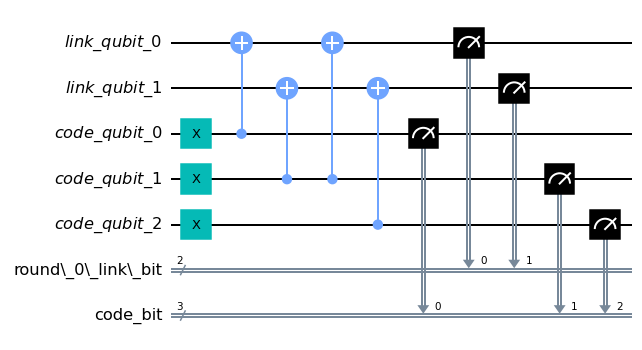

In [27]:
#code.circuit['1'].draw()
qc1=code.circuit['1']
qc1.draw(output='mpl')


In [28]:
raw_results = {}
noise_model = get_noise(0.1,0.05,0.03)
#logical 0
job = execute(qc0, Aer.get_backend('qasm_simulator'), noise_model=noise_model)
raw_results[str(0)] = job.result().get_counts()

In [29]:
#logical 1
job = execute(qc1, Aer.get_backend('qasm_simulator'), noise_model=noise_model)
raw_results[str(1)] = job.result().get_counts()
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'011 11': 1, '110 10': 4, '001 10': 11, '011 00': 8, '110 01': 4, '111 10': 1, '000 10': 77, '100 00': 58, '111 01': 1, '101 00': 8, '001 11': 3, '010 00': 72, '101 10': 2, '100 10': 12, '011 01': 2, '000 01': 98, '110 00': 16, '000 00': 495, '010 11': 4, '001 01': 20, '010 01': 24, '000 11': 17, '001 00': 69, '100 01': 9, '010 10': 8} 

Logical 1 : {'001 11': 1, '001 01': 3, '010 01': 4, '010 00': 11, '001 10': 3, '011 11': 4, '110 10': 7, '110 01': 23, '011 10': 21, '100 11': 2, '001 00': 12, '110 11': 6, '111 11': 10, '101 10': 21, '100 10': 5, '111 01': 74, '101 00': 71, '111 00': 445, '111 10': 94, '011 00': 71, '011 01': 8, '100 01': 6, '010 10': 6, '110 00': 64, '101 11': 25, '100 00': 4, '101 01': 23} 



In [38]:
from qiskit.visualization import plot_histogram 
#plot_histogram(raw_results[str(0)])
#plot_histogram(raw_results[str(1)])

In [30]:
#To get the lookup table
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=10000 )
    table_results[str(log)] = job.result().get_counts(str(log))

In [31]:
P = lookuptable_decoding(raw_results,table_results) #This gives the probability of incorrect decoding
print('P =',P)

P = {'0': 0.0458, '1': 0.0555}


In [40]:
#Running on the hardware backend
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)

Enter email:


 darekar@usc.edu


Enter password


 ···················


In [41]:
QI.backends()



[<QuantumInspireBackend('Spin-2')>,
 <QuantumInspireBackend('Starmon-5')>,
 <QuantumInspireBackend('QX-34-L')>,
 <QuantumInspireBackend('QX single-node simulator')>]

In [42]:
qi_backend = QI.get_backend('Starmon-5')
raw_results_device = {}

job_device=execute(qc0, backend=qi_backend, shots=512)

raw_results_device[str(0)] = job_device.result().get_counts()


In [43]:
job_device=execute(qc1, backend=qi_backend, shots=512)

raw_results_device[str(1)] = job_device.result().get_counts()


In [48]:
P = lookuptable_decoding(raw_results_device,table_results)
print('P =',P)

P = {'0': 0.0877, '1': 0.0343}


In [17]:
#for log in raw_results_device:
#    print('Logical',log,':',raw_results_device[log],'\n')

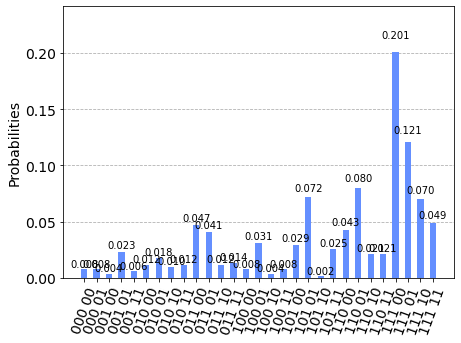

In [50]:
#plot_histogram(raw_results_device[str(0)])
plot_histogram(raw_results_device[str(1)])

In [ ]:
#Error mitigation
